In [1]:
import numpy as np
import scipy.signal as signal
import pandas as pd
import matplotlib.pyplot as plt
import regex as re

In [2]:
import segyio

In [3]:
data_path = "cdpgathers_82-140.sgy"

In [4]:
f = segyio.open(data_path, ignore_geometry=True)
f

SegyFile('cdpgathers_82-140.sgy', 'r', iline = 189, xline = 193)

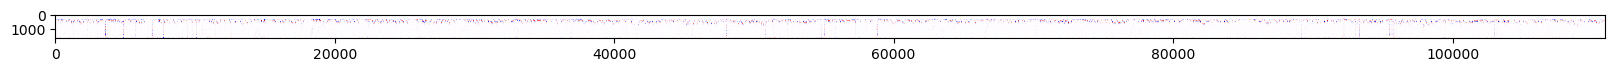

In [5]:
clip = 1e+2
vmin, vmax = -clip, clip

# Figure
figsize=(20, 20)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=figsize, facecolor='w', edgecolor='k',
                       squeeze=False,
                       sharex=True)
axs = axs.ravel()
im = axs[0].imshow(f.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax)

In [6]:
f.close()

In [7]:
from obspy.io.segy.core import _read_segy

In [8]:
data_path_2 = "cdpgathers_82-140.sgy"

In [9]:
# Read SEGY file
st = _read_segy(data_path_2)

# Obtain number of traces and samples per trace
num_traces  = st.count()
num_samples = st.stats.binary_file_header['number_of_samples_per_data_trace']

# Allocation for traces
traces = np.zeros((num_traces,num_samples))

# Put the trace data in an nd-array
for i, tr in enumerate(st.traces):
    traces[i,:] = tr.data

In [10]:
sampling_period = st.stats.binary_file_header['sample_interval_in_microseconds']

# sampling interval in seconds
dt = 1e-6 * sampling_period  # in seconds

# time domain in seconds
time_domain = dt*np.arange(num_samples, dtype=float)

# sampling frequency
df = 1/dt  # in Hertz
        
# Nyquist Frequency
nyquist = 1/(2*dt)

# frequency domain in Hertz
freq_domain = np.fft.rfftfreq(n=num_samples, d=dt)

# 
print("Sample rate        = %f milli seconds" % (dt * 1000.0))
print("Nyquist frequency  = %f Hz" % nyquist)
print("Sampling frequency = %f Hz" % df)

Sample rate        = 2.000000 milli seconds
Nyquist frequency  = 250.000000 Hz
Sampling frequency = 500.000000 Hz


In [11]:
st

110925 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.298000Z | 500.0 Hz, 1650 samples
...
(110923 other traces)
...
Seq. No. in line: 110925 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:03.298000Z | 500.0 Hz, 1650 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [12]:
st.count()

110925

In [13]:
st.stats.textual_file_header

b'C 1 CLIENT                        COMPANY                       CREW NO         C 2 LINE                                                                        C 3 REEL NO 123456                                                              C 4                                                                             C 5                                                                             C 6                                                                             C 7                                                                             C 8                                                                             C 9                                                                             C10                                                                             C11                                                                             C12                                                                             C13                                   

In [14]:
st.stats.binary_file_header

AttribDict({'endian': '>', 'job_identification_number': 0, 'line_number': 0, 'reel_number': 123456, 'number_of_data_traces_per_ensemble': 36, 'number_of_auxiliary_traces_per_ensemble': 0, 'sample_interval_in_microseconds': 2000, 'sample_interval_in_microseconds_of_original_field_recording': 0, 'number_of_samples_per_data_trace': 1650, 'number_of_samples_per_data_trace_for_original_field_recording': 0, 'data_sample_format_code': 1, 'ensemble_fold': 36, 'trace_sorting_code': 2, 'vertical_sum_code': 0, 'sweep_frequency_at_start': 0, 'sweep_frequency_at_end': 0, 'sweep_length': 0, 'sweep_type_code': 0, 'trace_number_of_sweep_channel': 0, 'sweep_trace_taper_length_in_ms_at_start': 0, 'sweep_trace_taper_length_in_ms_at_end': 0, 'taper_type': 0, 'correlated_data_traces': 0, 'binary_gain_recovered': 0, 'amplitude_recovery_method': 0, 'measurement_system': 1, 'impulse_signal_polarity': 0, 'vibratory_polarity_code': 0, 'unassigned_1': b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

Text(0.5, 1.0, 'Raw Shot Gather')

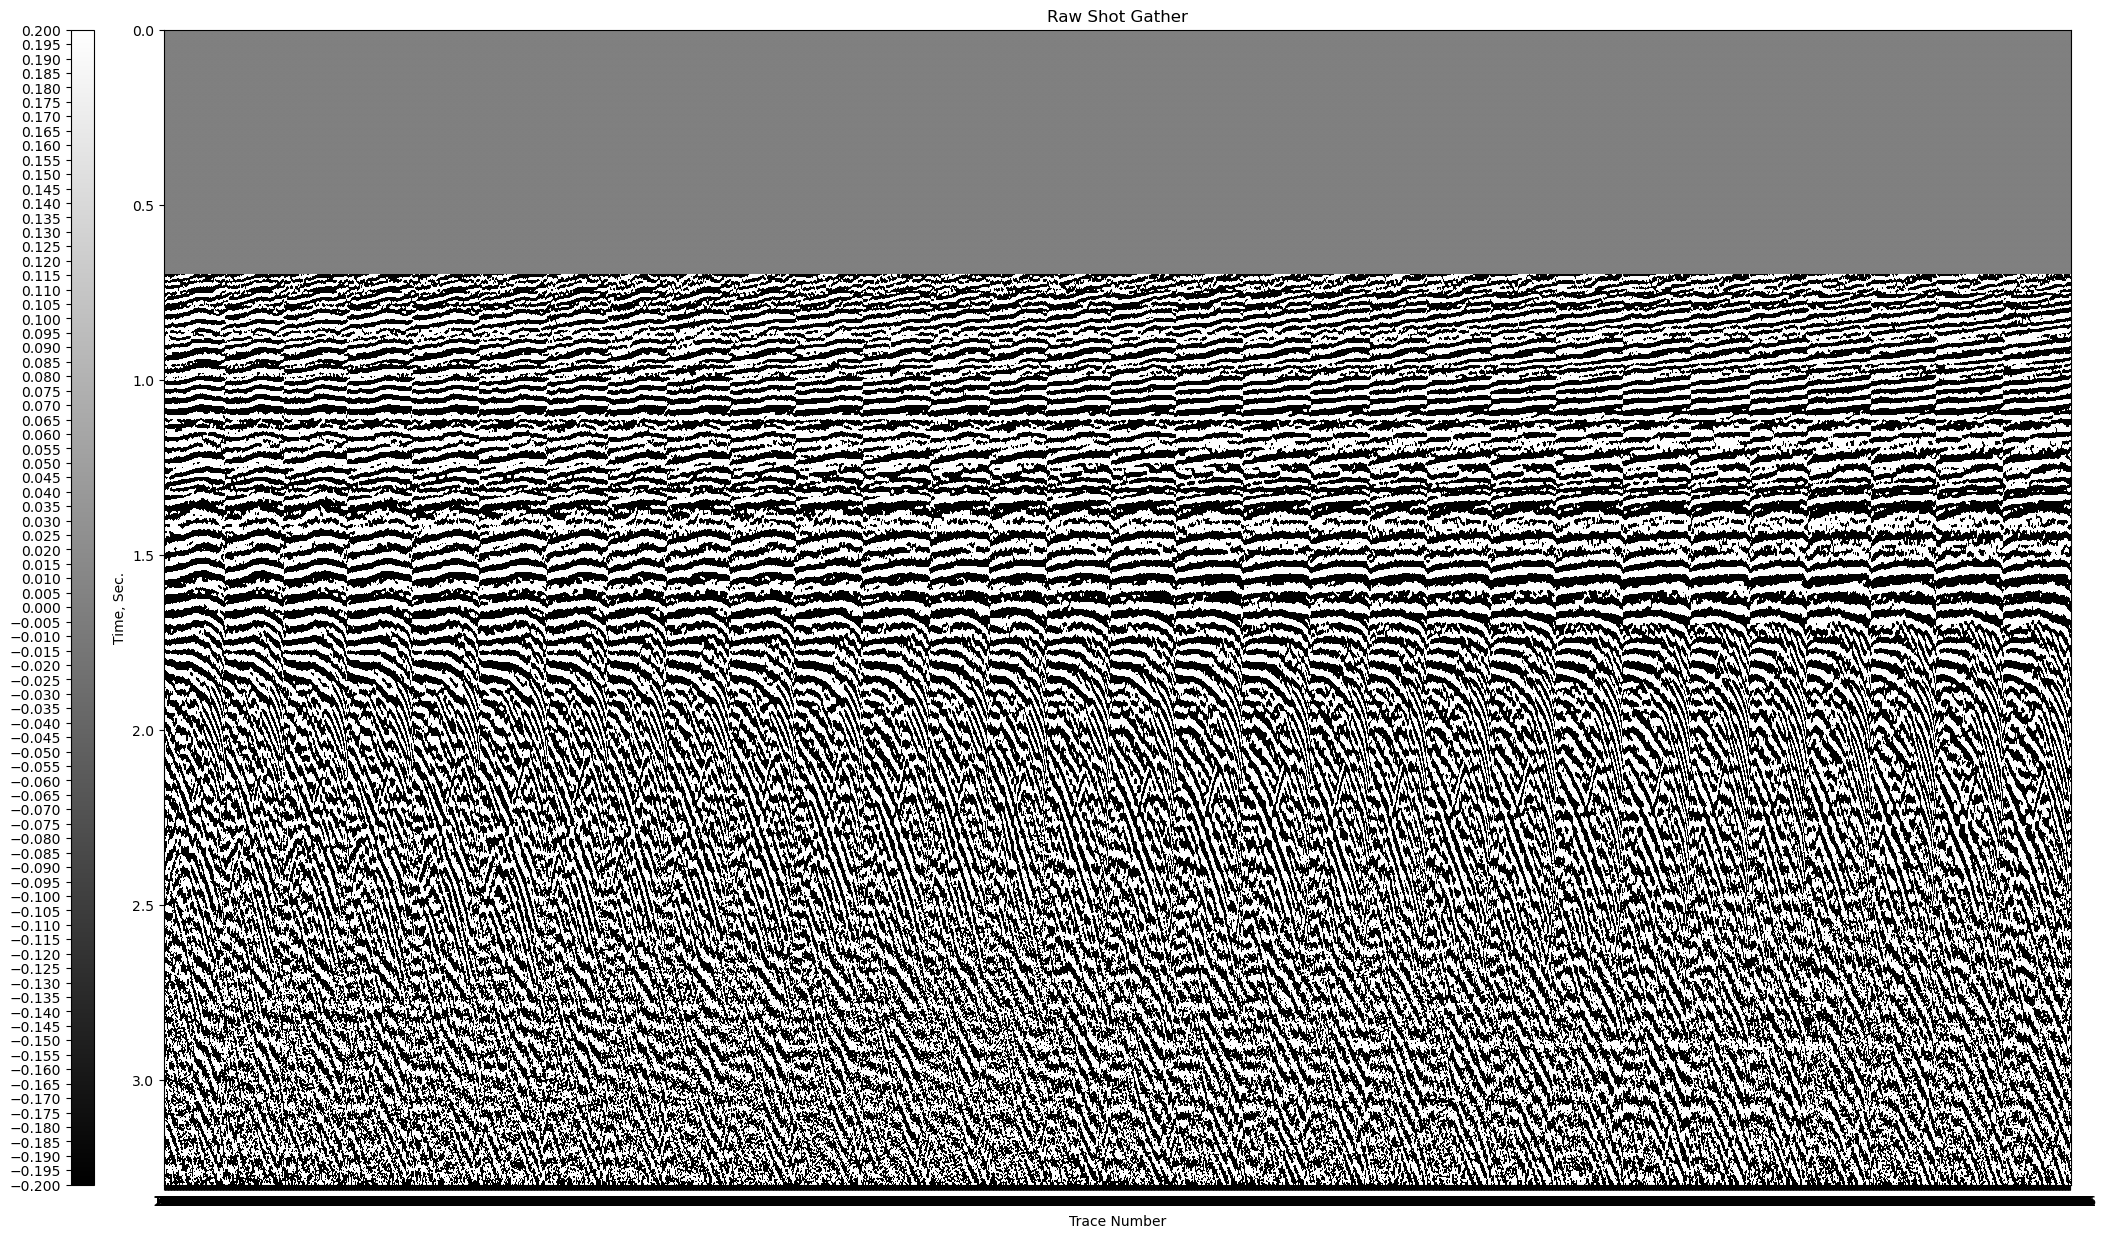

In [15]:
tmax = dt*(num_samples)

fig = plt.figure(figsize=(30, 15))
plt.imshow(np.transpose(traces), cmap='gray', aspect='auto', extent=(1, num_traces, tmax, 0), vmin=-0.2, vmax=0.2)

plt.xticks(np.arange(1,num_traces,25))
plt.yticks(np.arange(0,tmax,0.5))
plt.colorbar(location='left', pad=0.03, aspect=50, ticks=np.arange(-0.200,0.200+0.005,0.005))
plt.xlabel('Trace Number')
plt.ylabel('Time, Sec.')

plt.title('Raw Shot Gather')

In [16]:
def parse_trace_headers(segyfile, n_traces):
    '''
    Parse the trace headers into a pandas dataframe.
    Column names are defined from segyio internal tracefield
    '''
    # Get all trace header keys
    headers = segyio.tracefield.keys
    
    # Initialize dataframe with trace id as index and headers as columns
    df = pd.DataFrame(index=range(1, n_traces+1), columns=headers.keys())
    
    # Fill dataframe with all trace header values
    for k, v in headers.items():
        df[k] = segyfile.attributes(v)[:]
        
    return df

In [17]:
with segyio.open(data_path, ignore_geometry=True) as f:
    
    # Get basic attributes
    n_traces    = f.tracecount                  # Number of traces
    sample_rate = segyio.tools.dt(f)/1000       # Sampling trace in micro second
    n_samples   = f.samples.size                # Number of samples in each trace data
    t_domain    = f.samples                     # Discretized time domain milli second
    tr_data     = f.trace.raw[:]                # Get all trace data into numpy array
    
    # Load headers
    trace_headers = parse_trace_headers(f, n_traces)
    
print(f'Number of Traces: {n_traces}, Number of Samples: {n_samples}, Sample Rate: {sample_rate} ms')

Number of Traces: 110925, Number of Samples: 1650, Sample Rate: 2.0 ms


In [18]:
trace_headers

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,...,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2
1,1,1,82,24607,500117,7,1,3,1,1,...,0,1651,0,2147418112,0,2193402,10,-10931,0,0
2,2,2,82,24607,500111,7,2,1,1,1,...,0,1651,0,2147418112,0,2193402,10,-10931,0,0
3,3,3,82,24608,500117,8,1,3,1,1,...,0,1651,0,2147418112,0,2193347,10,-10931,0,0
4,4,4,82,24608,500111,8,2,1,1,1,...,0,1651,0,2147418112,0,2193347,10,-10931,0,0
5,5,5,82,24609,500117,9,1,1,1,1,...,0,1651,0,2147418112,0,2193292,10,-10931,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110921,110921,110921,140,42229,612128,229,2,1,1,1,...,0,1651,0,2147418112,0,2181190,10,-7749,0,0
110922,110922,110922,140,42229,612122,229,3,1,1,1,...,0,1651,0,2147418112,0,2181190,10,-7749,0,0
110923,110923,110923,140,42230,612134,230,1,1,1,1,...,0,1651,0,2147418112,0,2181135,10,-7749,0,0
110924,110924,110924,140,42230,612128,230,2,1,1,1,...,0,1651,0,2147418112,0,2181135,10,-7749,0,0


In [19]:
trace_headers.keys()

Index(['TRACE_SEQUENCE_LINE', 'TRACE_SEQUENCE_FILE', 'FieldRecord',
       'TraceNumber', 'EnergySourcePoint', 'CDP', 'CDP_TRACE',
       'TraceIdentificationCode', 'NSummedTraces', 'NStackedTraces', 'DataUse',
       'offset', 'ReceiverGroupElevation', 'SourceSurfaceElevation',
       'SourceDepth', 'ReceiverDatumElevation', 'SourceDatumElevation',
       'SourceWaterDepth', 'GroupWaterDepth', 'ElevationScalar',
       'SourceGroupScalar', 'SourceX', 'SourceY', 'GroupX', 'GroupY',
       'CoordinateUnits', 'WeatheringVelocity', 'SubWeatheringVelocity',
       'SourceUpholeTime', 'GroupUpholeTime', 'SourceStaticCorrection',
       'GroupStaticCorrection', 'TotalStaticApplied', 'LagTimeA', 'LagTimeB',
       'DelayRecordingTime', 'MuteTimeStart', 'MuteTimeEND',
       'TRACE_SAMPLE_COUNT', 'TRACE_SAMPLE_INTERVAL', 'GainType',
       'InstrumentGainConstant', 'InstrumentInitialGain', 'Correlated',
       'SweepFrequencyStart', 'SweepFrequencyEnd', 'SweepLength', 'SweepType',
       'Swee

In [20]:
with segyio.open(data_path, ignore_geometry=True) as f:
    raw_header = segyio.tools.wrap(f.text[0])

In [21]:
raw_header

'C 1 CLIENT                        COMPANY                       CREW NO\nC 2 LINE\nC 3 REEL NO 123456\nC 4\nC 5\nC 6\nC 7\nC 8\nC 9\nC10\nC11\nC12\nC13\nC14\nC15\nC16\nC17\nC18\nC19\nC20\nC21\nC22\nC23  / JOB  xss00000    19 APR 93 / JOB  xss00000    19 APR 93    INPUT\n00000C24 1   SEGYI.24   EDRMV..7   EDLST..3 / JOB  xss00000    19 APR 93\nINPUT    C25 BEG.L041L055 BEG.L056L70   EDRMV..7   PROFL.17   EDLAB.10\nEDLAB.10   EDLABC26 .10   EDLST..3   SEGYOU24\nC27\nC28\nC29\nC30\nC31\nC32\nC33\nC34\nC35\nC36\nC37\nC38\nC39\nC40'

In [22]:
def parse_text_header_1(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header = re.split(r'C ', raw_header)[1:9]
    # Remove end of line return   
    text_header = [x[2:] for x in cut_header]
    text_header[-1] = text_header[-1][:-2]
    # Format in dict
    clean_header_1 = {}
    i = 1
    for item in text_header:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header_1[key] = item
    return clean_header_1



In [23]:
def parse_text_header_2(segyfile):
    '''
    Format segy text header into a readable, clean dict
    '''
    raw_header = segyio.tools.wrap(segyfile.text[0])
    # Cut on C*int pattern
    cut_header_2 = re.split(r'C', raw_header)[12::]
    # Remove end of line return 
    text_header_2 = [x[2:] for x in cut_header_2]
    text_header_2[-1] = text_header_2[-1][:-2]
    #text_header_2 = [(x.strip()) for x in cut_header_2]
    #print(type(text_header_2))
    #print(text_header_2)
    
    # Format in dict
    clean_header_2 = {}
    i = 9
    for item in text_header_2:
        key = "C" + str(i).rjust(2, '0')
        i += 1
        clean_header_2[key] = item
        
    return clean_header_2

In [24]:
with segyio.open(data_path, ignore_geometry=True) as f:
    
    # Get basic attributes
    n_traces    = f.tracecount                  # Number of traces
    sample_rate = segyio.tools.dt(f)/1000       # Sampling trace in micro second
    n_samples   = f.samples.size                # Number of samples in each trace data
    t_domain    = f.samples                     # Discretized time domain milli second
    tr_data     = f.trace.raw[:]                # Get all trace data into numpy array
    
    # Load headers
    trace_headers = parse_trace_headers(f, n_traces)
    text_headers_1 = parse_text_header_1(f)    
    text_headers_2 = parse_text_header_2(f)
    bin_headers = f.bin
               
print(f'Number of Traces: {n_traces}, Number of Samples: {n_samples}, Sample Rate: {sample_rate} ms')

Number of Traces: 110925, Number of Samples: 1650, Sample Rate: 2.0 ms


In [25]:
def Merge(dict1, dict2):
    res = {**dict1,**dict2}
    return res

In [26]:
dict3 = Merge(text_headers_1,text_headers_2)

In [27]:
dict3

{'C01': 'CLIENT                        COMPANY                       CREW NO\n',
 'C02': 'LINE\n',
 'C03': 'REEL NO 123456\n',
 'C04': '',
 'C05': '',
 'C06': '',
 'C07': '',
 'C08': '',
 'C09': '\n',
 'C10': '\n',
 'C11': '\n',
 'C12': '\n',
 'C13': '\n',
 'C14': '\n',
 'C15': '\n',
 'C16': '\n',
 'C17': '\n',
 'C18': '\n',
 'C19': '\n',
 'C20': '\n',
 'C21': '\n',
 'C22': '\n',
 'C23': '  / JOB  xss00000    19 APR 93 / JOB  xss00000    19 APR 93    INPUT\n00000',
 'C24': ' 1   SEGYI.24   EDRMV..7   EDLST..3 / JOB  xss00000    19 APR 93\nINPUT    ',
 'C25': ' BEG.L041L055 BEG.L056L70   EDRMV..7   PROFL.17   EDLAB.10\nEDLAB.10   EDLAB',
 'C26': ' .10   EDLST..3   SEGYOU24\n',
 'C27': '\n',
 'C28': '\n',
 'C29': '\n',
 'C30': '\n',
 'C31': '\n',
 'C32': '\n',
 'C33': '\n',
 'C34': '\n',
 'C35': '\n',
 'C36': '\n',
 'C37': '\n',
 'C38': '\n',
 'C39': '\n',
 'C40': ''}

In [28]:
#To create a new dictionary, dictionary comprehension can be used:
testDict = {key: value.rstrip() for key, value in dict3.items()}
#To update the dictionary in-place, just iterate over it and 
#apply str.rstrip() to values:
for key, value in testDict.items():
    testDict[key] = value.rstrip()

In [29]:
testDict

{'C01': 'CLIENT                        COMPANY                       CREW NO',
 'C02': 'LINE',
 'C03': 'REEL NO 123456',
 'C04': '',
 'C05': '',
 'C06': '',
 'C07': '',
 'C08': '',
 'C09': '',
 'C10': '',
 'C11': '',
 'C12': '',
 'C13': '',
 'C14': '',
 'C15': '',
 'C16': '',
 'C17': '',
 'C18': '',
 'C19': '',
 'C20': '',
 'C21': '',
 'C22': '',
 'C23': '  / JOB  xss00000    19 APR 93 / JOB  xss00000    19 APR 93    INPUT\n00000',
 'C24': ' 1   SEGYI.24   EDRMV..7   EDLST..3 / JOB  xss00000    19 APR 93\nINPUT',
 'C25': ' BEG.L041L055 BEG.L056L70   EDRMV..7   PROFL.17   EDLAB.10\nEDLAB.10   EDLAB',
 'C26': ' .10   EDLST..3   SEGYOU24',
 'C27': '',
 'C28': '',
 'C29': '',
 'C30': '',
 'C31': '',
 'C32': '',
 'C33': '',
 'C34': '',
 'C35': '',
 'C36': '',
 'C37': '',
 'C38': '',
 'C39': '',
 'C40': ''}

In [30]:
a=dict3.keys()
a

dict_keys(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40'])

In [31]:
def get_nth_key(dict3, n=0):
    if n < 0:
        n += len(dict3)
    for i, key in enumerate(dict3.keys()):
        if i == n:
            return key
    raise IndexError("dictionary index out of range") 

    
nth_val = dict3[get_nth_key(dict3, n=0)]
nth_val
type(nth_val)
print(nth_val[2:])

IENT                        COMPANY                       CREW NO



In [32]:
dict3

{'C01': 'CLIENT                        COMPANY                       CREW NO\n',
 'C02': 'LINE\n',
 'C03': 'REEL NO 123456\n',
 'C04': '',
 'C05': '',
 'C06': '',
 'C07': '',
 'C08': '',
 'C09': '\n',
 'C10': '\n',
 'C11': '\n',
 'C12': '\n',
 'C13': '\n',
 'C14': '\n',
 'C15': '\n',
 'C16': '\n',
 'C17': '\n',
 'C18': '\n',
 'C19': '\n',
 'C20': '\n',
 'C21': '\n',
 'C22': '\n',
 'C23': '  / JOB  xss00000    19 APR 93 / JOB  xss00000    19 APR 93    INPUT\n00000',
 'C24': ' 1   SEGYI.24   EDRMV..7   EDLST..3 / JOB  xss00000    19 APR 93\nINPUT    ',
 'C25': ' BEG.L041L055 BEG.L056L70   EDRMV..7   PROFL.17   EDLAB.10\nEDLAB.10   EDLAB',
 'C26': ' .10   EDLST..3   SEGYOU24\n',
 'C27': '\n',
 'C28': '\n',
 'C29': '\n',
 'C30': '\n',
 'C31': '\n',
 'C32': '\n',
 'C33': '\n',
 'C34': '\n',
 'C35': '\n',
 'C36': '\n',
 'C37': '\n',
 'C38': '\n',
 'C39': '\n',
 'C40': ''}

In [33]:
get_nth_key(dict3, n=0)

'C01'

In [34]:
get_nth_key(dict3, n=-1)

'C40'